# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)
5. [Other data](#Other-data)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import numpy as np

import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
from lob_data_utils.roc_results import results_15000 as results

df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, cv=True, length=15000)
    if np.any(d):
        dfs[s] = d
        dfs_test[s] = d_test

In [3]:
stocks = dfs.keys()
print(len(stocks))

13


In [4]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
2,9094,0.564523
8,9067,0.561571
4,9061,0.550878
1,9063,0.550200
9,9265,0.549511


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

In [5]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
bid_len = []
ask_len = []
mean_bid_ask_len = []
mean_bid_len = []
mean_ask_len = []
from scipy.stats import pearsonr
for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

    max_len_bid = 0
    max_len_ask = 0
        
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])
    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)

    sum_len_bid_ask = 0
    sum_len_bid = 0
    sum_len_ask = 0
    for i, row in dfs[s].iterrows():
        sum_len_bid_ask += (len(row['ask']) + len(row['bid']))
        sum_len_bid += len(row['bid'])
        sum_len_ask += len(row['ask'])
    mean_bid_ask_len.append(sum_len_bid_ask/(2 * len(dfs[s])))
    mean_bid_len.append(sum_len_bid/len(dfs[s]))
    mean_ask_len.append(sum_len_ask/len(dfs[s]))
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len
df_summary['mean_bid_ask_len'] = mean_bid_ask_len
df_summary['mean_bid_len'] = mean_bid_len
df_summary['mean_ask_len'] = mean_ask_len

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.56]

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len
9094,0.564523,1929.417222,2012.076444,-82.659222,1689.5,1451.5,238.0,1.013611,1490,1324,1053.530500,950.335667,1156.725333
9067,0.561571,1062.150222,1049.581889,12.568333,3417.0,3109.5,307.5,1.055944,1206,1739,962.915667,1074.221000,851.610333


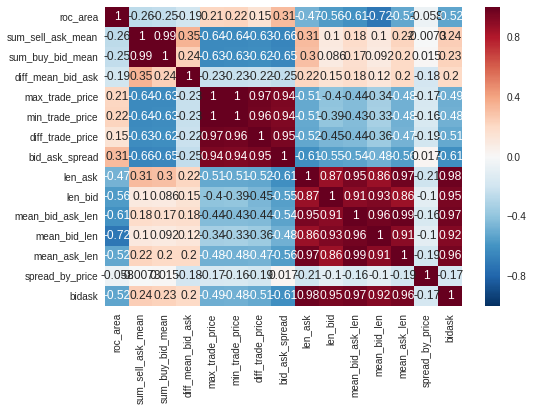

In [6]:
df_summary['spread_by_price'] = df_summary['bid_ask_spread'] / df_summary['diff_trade_price']
df_summary['bidask'] = (df_summary['len_bid'] + df_summary['len_ask'])/2
sns.heatmap(df_summary.corr(), annot=True)

In [7]:
df_summary.sort_values(by='roc_area')

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,spread_by_price,bidask
9062,0.522461,990.060111,996.598667,-6.538556,3351.00,2937.00,414.00,0.999056,2517,2258,1917.872667,1822.715222,2013.030111,0.002413,2387.5
12059,0.530526,5667.953333,5446.236778,221.716556,391.30,350.50,40.80,0.225400,1696,2032,1286.279611,1393.319556,1179.239667,0.005525,1864.0
11244,0.531522,3947.334556,4092.047333,-144.712778,355.50,324.30,31.20,0.115528,3028,2576,2231.846944,1956.802667,2506.891222,0.003703,2802.0
9064,0.536324,27371.843222,27615.118889,-243.275667,79.85,72.70,7.15,0.025367,2204,1813,1421.505500,1330.297556,1512.713444,0.003548,2008.5
9069,0.536358,16291.703333,13280.709667,3010.993667,308.05,263.10,44.95,0.096556,2329,1985,1616.291222,1447.088333,1785.494111,0.002148,2157.0
10166,0.544253,772.453000,840.732222,-68.279222,3454.50,2965.00,489.50,1.216444,1222,1446,895.660278,949.992111,841.328444,0.002485,1334.0
9058,0.544432,2979.733000,3185.756556,-206.023556,1999.00,1764.00,235.00,0.785167,1916,1920,1426.431444,1364.049111,1488.813778,0.003341,1918.0
9269,0.547271,5143.672889,5695.949333,-552.276444,403.05,343.00,60.05,0.108339,1676,1903,1328.736944,1342.754444,1314.719444,0.001804,1789.5
9265,0.549511,1238.612444,1337.303556,-98.691111,3549.00,3163.50,385.50,0.951000,1698,1727,1216.601222,1277.771667,1155.430778,0.002467,1712.5
9063,0.550200,8298.177667,7802.540667,495.637000,468.00,427.05,40.95,0.091628,3101,2535,1863.247500,1600.021111,2126.473889,0.002238,2818.0


In [8]:
print(df_summary['roc_area'].min(), df_summary['roc_area'].max())
df_summary[['roc_area', 'mean_bid_len', 'mean_bid_ask_len',  'bidask']].sort_values(by='mean_bid_ask_len')

0.522461360682 0.564522738408


,roc_area,mean_bid_len,mean_bid_ask_len,bidask
10166,0.544253,949.992111,895.660278,1334.0
9067,0.561571,1074.221000,962.915667,1472.5
9094,0.564523,950.335667,1053.530500,1407.0
9265,0.549511,1277.771667,1216.601222,1712.5
12059,0.530526,1393.319556,1286.279611,1864.0
9269,0.547271,1342.754444,1328.736944,1789.5
9064,0.536324,1330.297556,1421.505500,2008.5
9058,0.544432,1364.049111,1426.431444,1918.0
9061,0.550878,1297.906333,1477.019556,2047.0
9069,0.536358,1447.088333,1616.291222,2157.0


In [9]:
df_summary[['roc_area', 'diff_mean_bid_ask', 'diff_trade_price', 
            'max_trade_price', 'min_trade_price',
            'spread_by_price']].sort_values(by='spread_by_price')

,roc_area,diff_mean_bid_ask,diff_trade_price,max_trade_price,min_trade_price,spread_by_price
9269,0.547271,-552.276444,60.05,403.05,343.00,0.001804
9069,0.536358,3010.993667,44.95,308.05,263.10,0.002148
9063,0.550200,495.637000,40.95,468.00,427.05,0.002238
9062,0.522461,-6.538556,414.00,3351.00,2937.00,0.002413
9265,0.549511,-98.691111,385.50,3549.00,3163.50,0.002467
10166,0.544253,-68.279222,489.50,3454.50,2965.00,0.002485
9061,0.550878,-305.405556,67.90,730.20,662.30,0.002565
9058,0.544432,-206.023556,235.00,1999.00,1764.00,0.003341
9067,0.561571,12.568333,307.50,3417.00,3109.50,0.003434
9064,0.536324,-243.275667,7.15,79.85,72.70,0.003548


In [10]:
df_summary['spread_by_price_diff'] = df_summary['diff_trade_price'] *  df_summary['bid_ask_spread']
df_summary.corr()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,spread_by_price,bidask,spread_by_price_diff
roc_area,1.000000,-0.259463,-0.245703,-0.190149,0.211162,0.218856,0.147944,0.314767,-0.474160,-0.563792,-0.605612,-0.718990,-0.516524,-0.058201,-0.524255,0.144129
sum_sell_ask_mean,-0.259463,1.000000,0.993503,0.349816,-0.638172,-0.636928,-0.626732,-0.660380,0.314929,0.100527,0.179959,0.103007,0.219367,-0.007306,0.242626,-0.575620
sum_buy_bid_mean,-0.245703,0.993503,1.000000,0.240924,-0.632871,-0.631492,-0.622593,-0.654298,0.299745,0.086431,0.165102,0.092244,0.202603,0.014879,0.227363,-0.570586
diff_mean_bid_ask,-0.190149,0.349816,0.240924,1.000000,-0.232751,-0.233495,-0.219798,-0.245758,0.218310,0.145819,0.175616,0.119117,0.203001,-0.184776,0.197531,-0.212015
max_trade_price,0.211162,-0.638172,-0.632871,-0.232751,1.000000,0.999479,0.971599,0.941321,-0.512458,-0.401259,-0.435149,-0.336092,-0.478628,-0.166172,-0.486408,0.946856
min_trade_price,0.218856,-0.636928,-0.631492,-0.233495,0.999479,1.000000,0.963457,0.935582,-0.509603,-0.392334,-0.432450,-0.331365,-0.477233,-0.162511,-0.481120,0.937023
diff_trade_price,0.147944,-0.626732,-0.622593,-0.219798,0.971599,0.963457,1.000000,0.953077,-0.516882,-0.453777,-0.440920,-0.359925,-0.473438,-0.187666,-0.509512,0.988450
bid_ask_spread,0.314767,-0.660380,-0.654298,-0.245758,0.941321,0.935582,0.953077,1.000000,-0.612816,-0.551909,-0.538906,-0.477790,-0.556096,0.017018,-0.609440,0.942995
len_ask,-0.474160,0.314929,0.299745,0.218310,-0.512458,-0.509603,-0.516882,-0.612816,1.000000,0.866403,0.952267,0.861346,0.972478,-0.205278,0.981307,-0.537566
len_bid,-0.563792,0.100527,0.086431,0.145819,-0.401259,-0.392334,-0.453777,-0.551909,0.866403,1.000000,0.906207,0.931423,0.858905,-0.102502,0.946306,-0.481978


In [11]:
df_by_len = df_summary.sort_values(by='mean_bid_len')
df_by_len.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len,spread_by_price,bidask,spread_by_price_diff
10166,0.544253,772.453000,840.732222,-68.279222,3454.5,2965.0,489.5,1.216444,1222,1446,895.660278,949.992111,841.328444,0.002485,1334.0,595.449556
9094,0.564523,1929.417222,2012.076444,-82.659222,1689.5,1451.5,238.0,1.013611,1490,1324,1053.530500,950.335667,1156.725333,0.004259,1407.0,241.239444
9067,0.561571,1062.150222,1049.581889,12.568333,3417.0,3109.5,307.5,1.055944,1206,1739,962.915667,1074.221000,851.610333,0.003434,1472.5,324.702917
9265,0.549511,1238.612444,1337.303556,-98.691111,3549.0,3163.5,385.5,0.951000,1698,1727,1216.601222,1277.771667,1155.430778,0.002467,1712.5,366.610500
9061,0.550878,6452.364000,6757.769556,-305.405556,730.2,662.3,67.9,0.174156,2271,1823,1477.019556,1297.906333,1656.132778,0.002565,2047.0,11.825162


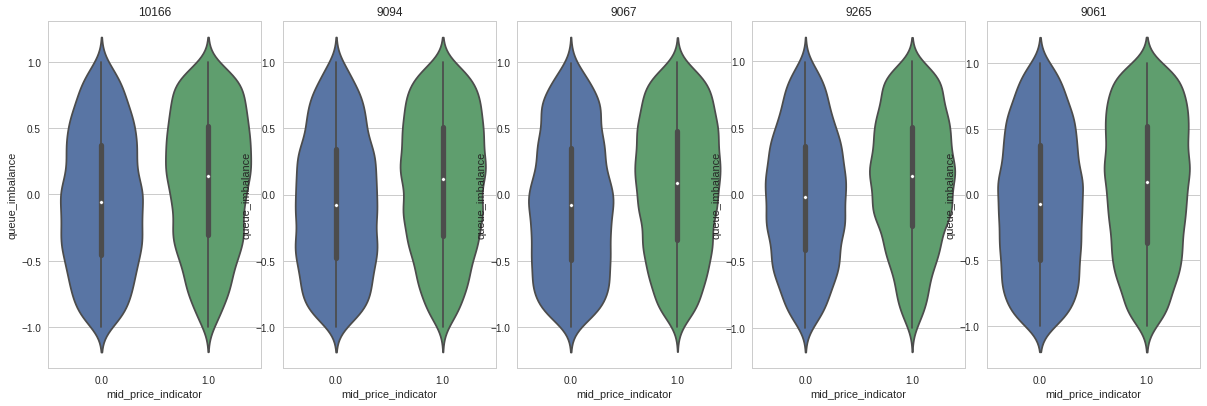

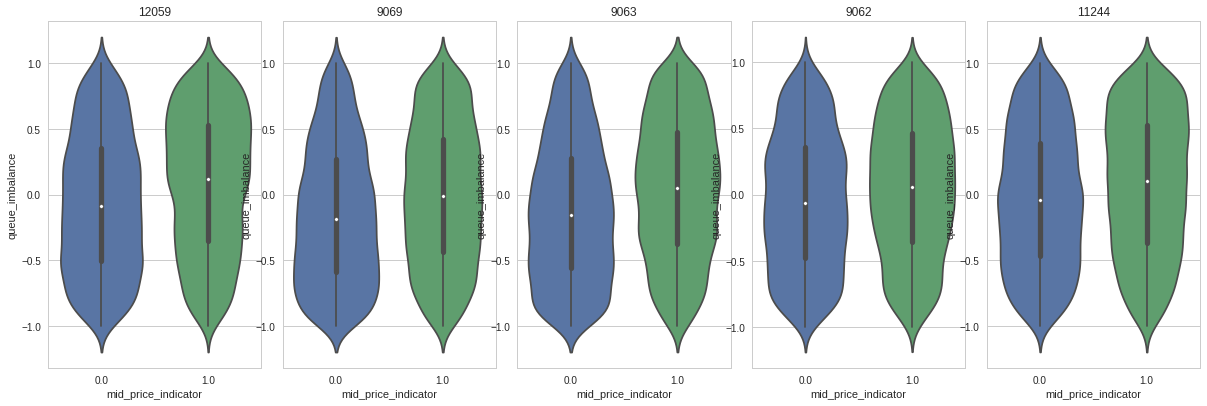

In [12]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=dfs[plot_stocks[i]], split=False, ax=axs[i],
                  label=plot_stocks[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

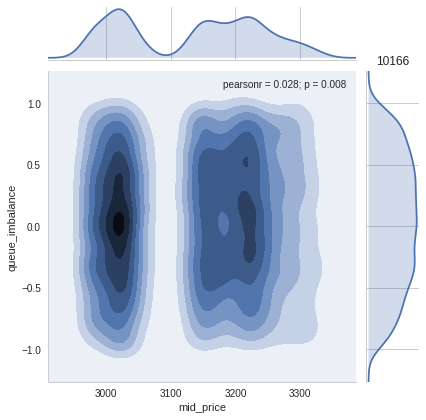

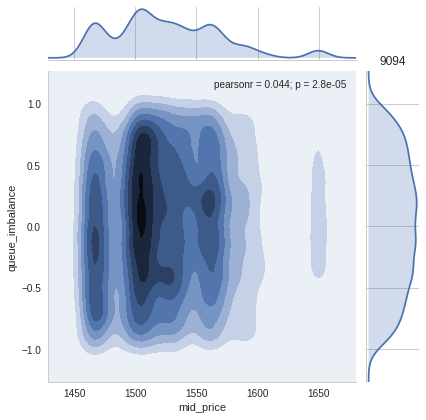

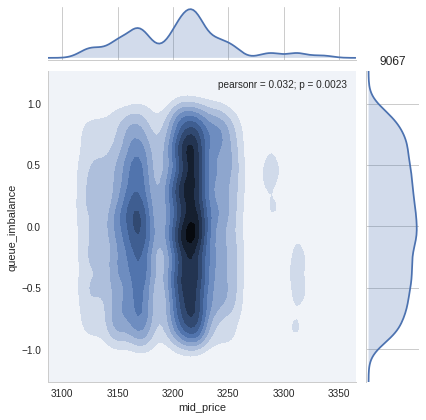

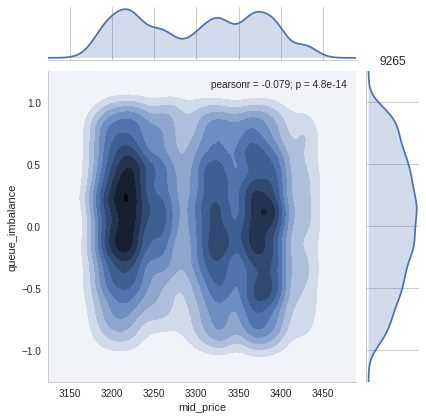

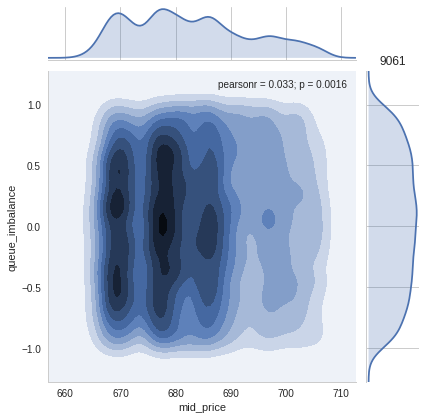

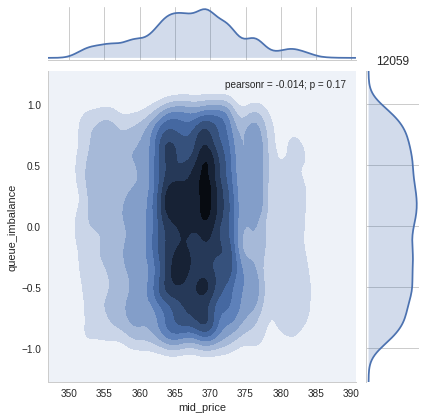

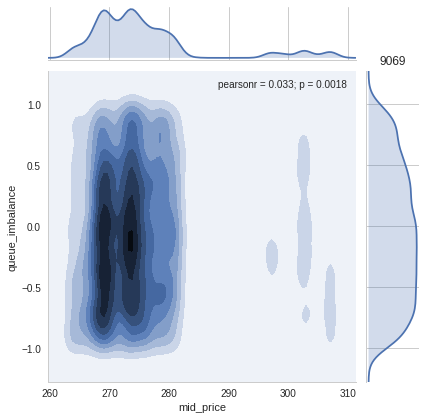

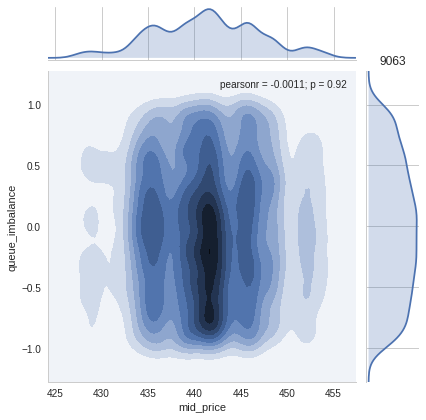

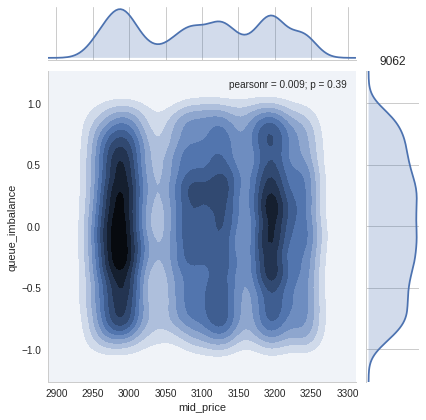

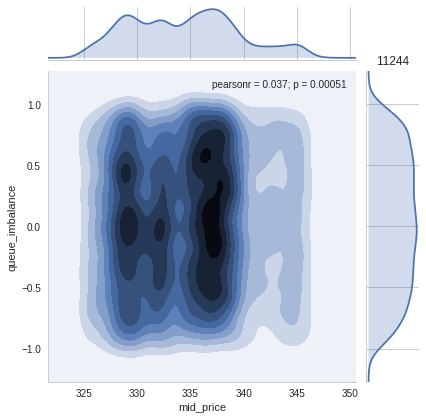

In [13]:
n = 5
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))

plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    sns.jointplot("mid_price", "queue_imbalance", data=dfs[plot_stocks[i]], 
                  kind='kde')
    plt.title(str(plot_stocks[i]))
#     sns.jointplot(x="mid_price", y="queue_imbalance", 
#               data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")

Axes(0.125,0.125;0.133621x0.755)
Axes(0.285345,0.125;0.133621x0.755)
Axes(0.44569,0.125;0.133621x0.755)
Axes(0.606034,0.125;0.133621x0.755)
Axes(0.766379,0.125;0.133621x0.755)


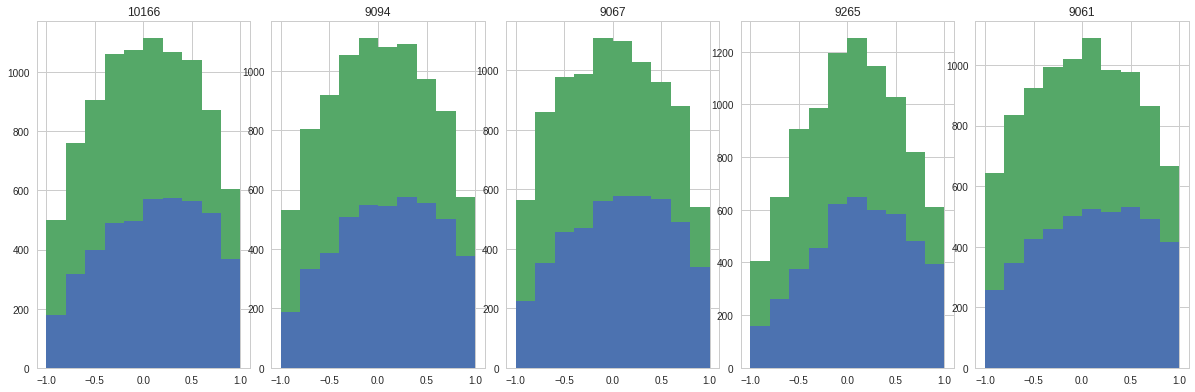

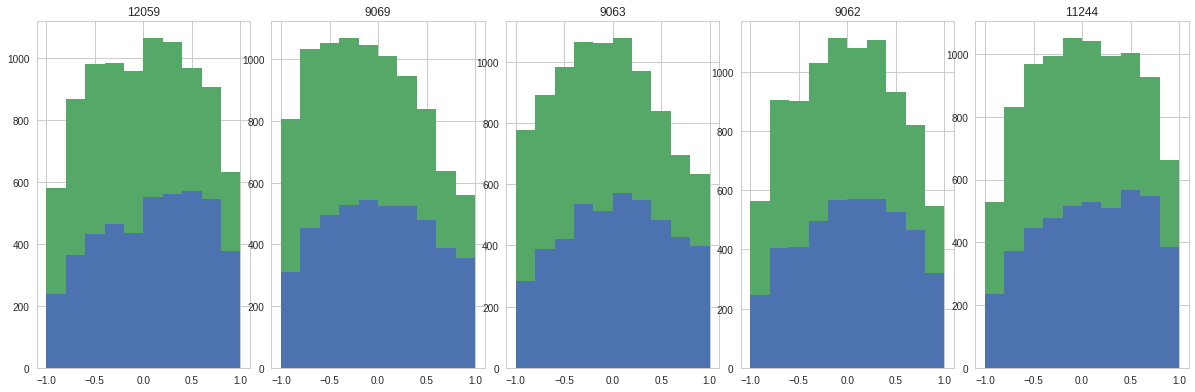

In [14]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    print(axs[i])
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    axs[i].hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
                  df[df['mid_price_indicator']==0]['queue_imbalance']],
             stacked=True, label = ['will raise', 'will not raise'])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)




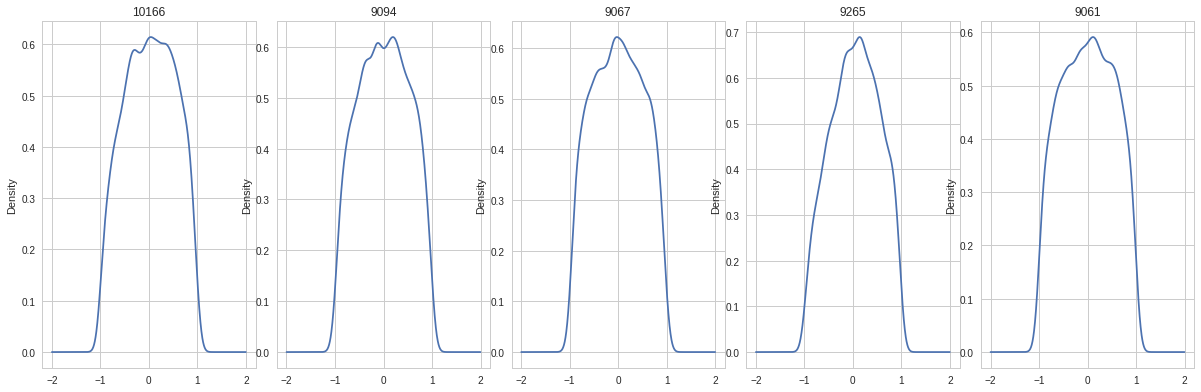

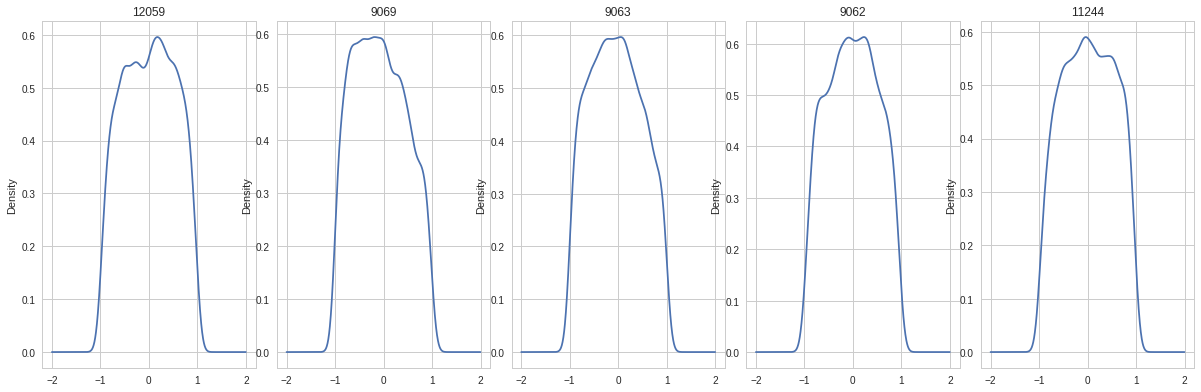

In [15]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    # df['mid_price'].plot('kde', ax=axs[i])
    df['queue_imbalance'].plot('kde', ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

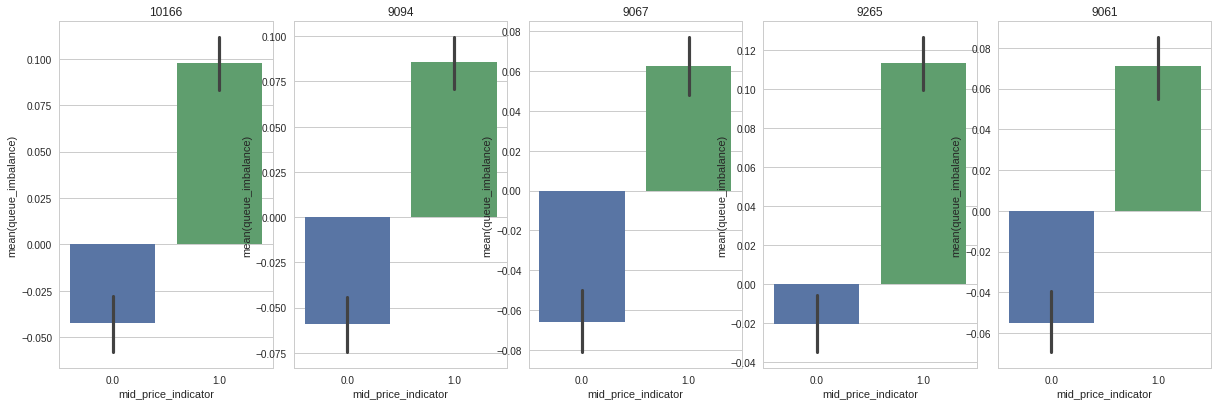

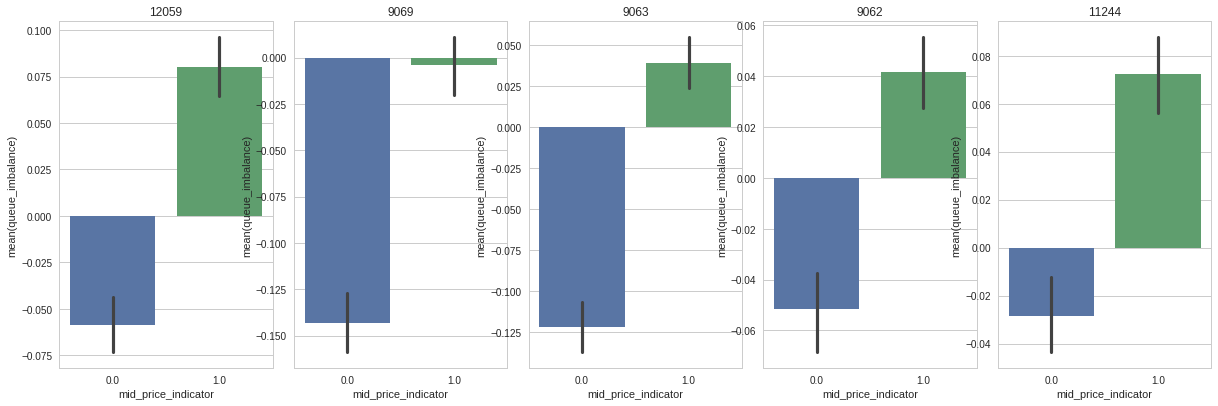

In [16]:
n = 5
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[0:n].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

plt.figure()
fig, axs = plt.subplots(ncols=n)
plot_stocks = df_by_len.iloc[len(df_roc) - n: len(df_roc)].index
for i in range(0, n):
    df = dfs[plot_stocks[i]]
    sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df, ax=axs[i])
    axs[i].set_title(str(plot_stocks[i]))
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

## Clustering data with all features

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit_predict(df_summary)

In [18]:
df_summary['class']= kmeans

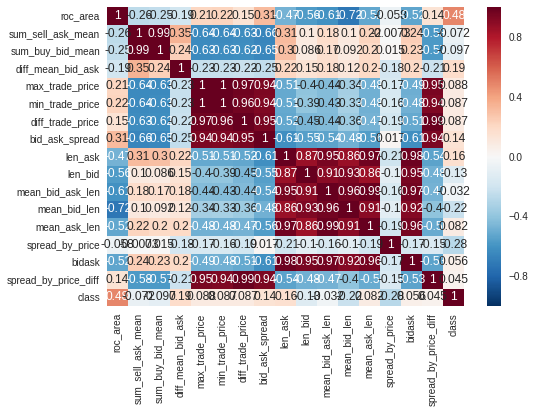

In [19]:
sns.heatmap(df_summary.corr(), annot=True)

In [ ]:
from pandas.plotting import scatter_matrix